<a href="https://colab.research.google.com/github/makaveli10/stylegan3/blob/main/face_merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Morphing - StyleGAN3
 Network details
 

In [ ]:
NETWORK = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl'
STEPS = 150
FPS = 30
FREEZE_STEPS = 30

## Upload images

In [ ]:
import os
from google.colab import files

uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for source.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    SOURCE_NAME = f"source{ext}"
    open(SOURCE_NAME, 'wb').write(v)

Saving vineet.png to vineet.png


In [ ]:
uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for target.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    TARGET_NAME = f"target{ext}"
    open(TARGET_NAME, 'wb').write(v)

Saving medel.png to medel.png


## CodeFormer Upsampling 
Upsample images if needed i.e. stylegan needs high resolution images to generate better latent vectors

In [ ]:
!git clone https://github.com/sczhou/CodeFormer.git

import sys
sys.path.insert(0, "/content/CodeFormer")
!pip install -r CodeFormer/requirements.txt
%cd CodeFormer
!python basicsr/setup.py develop
%cd ..
!python CodeFormer/scripts/download_pretrained_models.py facelib
!python CodeFormer/scripts/download_pretrained_models.py CodeFormer

Cloning into 'CodeFormer'...
remote: Enumerating objects: 468, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 468 (delta 36), reused 60 (delta 31), pack-reused 395
Receiving objects: 100% (468/468), 12.63 MiB | 18.39 MiB/s, done.
Resolving deltas: 100% (196/196), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 79.1 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
ERROR: pip's dependency 

Uncomment if codeformer upsampling needed.

In [ ]:
# CodeFormer restore image
# cmd = f"python CodeFormer/inference_codeformer.py -w 0.7 --input_path ./{SOURCE_NAME} -o ./"
# !{cmd}
# cmd = f"python CodeFormer/inference_codeformer.py -w 0.7 --input_path ./{TARGET_NAME} -o ./"
# !{cmd}

Face detection model: retinaface_resnet50
Background upsampling: False, Face upsampling: False
[1/1] Processing: source.jpg
	detect 1 faces

All results are saved in ./


In [ ]:
!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_5_face_landmarks.dat.bz2

--2023-02-02 11:22:58--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2’

shape_predictor_5_f 100%[===================>]   5.44M  1.19MB/s    in 5.1s    

2023-02-02 11:23:03 (1.06 MB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2’ saved [5706710/5706710]



In [ ]:
import sys
!git clone https://github.com/makaveli10/stylegan3
!pip install ninja
sys.path.insert(0, "/content/stylegan3")

Cloning into 'stylegan3'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 222 (delta 0), reused 16 (delta 0), pack-reused 205
Receiving objects: 100% (222/222), 4.20 MiB | 9.27 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 13.9 MB/s eta 0:00:00


## Detect face and crop

In [ ]:
import cv2
import numpy as np
from PIL import Image
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

def find_eyes(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 0)
  
  if len(rects) == 0:
    raise ValueError("No faces detected")
  elif len(rects) > 1:
    raise ValueError("Multiple faces detected")

  shape = predictor(gray, rects[0])
  features = []

  for i in range(0, 5):
    features.append((i, (shape.part(i).x, shape.part(i).y)))

  return (int(features[3][1][0] + features[2][1][0]) // 2, \
    int(features[3][1][1] + features[2][1][1]) // 2), \
    (int(features[1][1][0] + features[0][1][0]) // 2, \
    int(features[1][1][1] + features[0][1][1]) // 2)

def crop_stylegan(img):
  left_eye, right_eye = find_eyes(img)
  d = abs(right_eye[0] - left_eye[0])
  z = 255/d
  ar = img.shape[0]/img.shape[1]
  w = img.shape[1] * z
  img2 = cv2.resize(img, (int(w), int(w*ar)))
  bordersize = 1024
  img3 = cv2.copyMakeBorder(
      img2,
      top=bordersize,
      bottom=bordersize,
      left=bordersize,
      right=bordersize,
      borderType=cv2.BORDER_REPLICATE)

  left_eye2, right_eye2 = find_eyes(img3)

  crop1 = left_eye2[0] - 385 
  crop0 = left_eye2[1] - 490
  return img3[crop0:crop0+1024,crop1:crop1+1024]

source.png


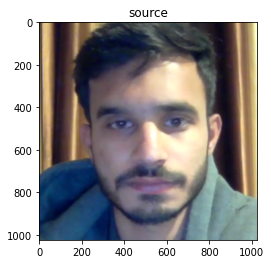

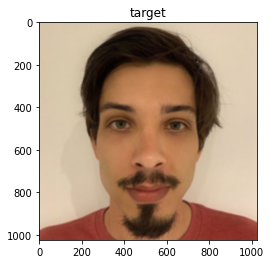

True

In [ ]:
from matplotlib import pyplot as plt
import cv2
print(SOURCE_NAME)
# image_source = cv2.imread(SOURCE_NAME)
image_source = cv2.imread(f"./final_results/{SOURCE_NAME.split('.')[0]}.png")
if image_source is None:
    raise ValueError("Source image not found")

image_target = cv2.imread(TARGET_NAME)
# image_target = cv2.imread(f"./final_results/{TARGET_NAME}")
if image_target is None:
    raise ValueError("Source image not found")

cropped_source = crop_stylegan(image_source)
cropped_target = crop_stylegan(image_target)

img = cv2.cvtColor(cropped_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

img = cv2.cvtColor(cropped_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target')
plt.show()

cv2.imwrite("cropped_source.png", cropped_source)
cv2.imwrite("cropped_target.png", cropped_target)

#print(find_eyes(cropped_source))
#print(find_eyes(cropped_target))

## Generate StyleGAN3 Latents

In [ ]:
cmd = f"python /content/stylegan3/projector.py --save-video 0 --num-steps 1000 --outdir=vineet --target=cropped_source.png --network={NETWORK}"
!{cmd}

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1194: UserWarning: operator() profile_node %105 : int = prim::profile_ivalue(%103)
 does not have profile information (Triggered internally at ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:105.)
  return forward_call(*input, **kwargs)
step    1/1000: dist 0.56 loss 0.56 
step    2/1000: dist 0.54 loss 0.54 
step    3/1000: dist 0.58 loss 0.58 
step    4/1000: dist 0.62 loss 0.62 
step    5/1000: dist 0.60 loss 0.60 
step    6/1000: dist 0.58 loss 0.58 
step    7/1000: dist 0.61 loss 0.61 
step    8/1000: dist 0.55 loss 0.55 
step    9/1000: dist 0.59 loss 0.59 
step   10/1000: dist 0.52 loss 0.52 
step   11/1000: dist 0.

In [ ]:
cmd = f"python /content/stylegan3/projector.py --save-video 0 --num-steps 1000 --outdir=medel --target=cropped_target.png --network={NETWORK}"
!{cmd}

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1194: UserWarning: operator() profile_node %105 : int = prim::profile_ivalue(%103)
 does not have profile information (Triggered internally at ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:105.)
  return forward_call(*input, **kwargs)
step    1/1000: dist 0.64 loss 0.64 
step    2/1000: dist 0.57 loss 0.57 
step    3/1000: dist 0.66 loss 0.66 
step    4/1000: dist 0.64 loss 0.64 
step    5/1000: dist 0.70 loss 0.70 
step    6/1000: dist 0.58 loss 0.58 
step    7/1000: dist 0.60 loss 0.60 
step    8/1000: dist 0.52 loss 0.52 
step    9/1000: dist 0.71 loss 0.71 
step   10/1000: dist 0.52 loss 0.52 
step   11/1000: dist 0.

In [ ]:
img_gan_source = cv2.imread('/content/vineet/proj.png')
img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source-gan')
plt.show()

error: ignored

In [ ]:
img_gan_target = cv2.imread('/content/out_target/proj.png')
img = cv2.cvtColor(img_gan_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target-gan')
plt.show()

In [ ]:
!pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 54.4 MB/s eta 0:00:00


## Merge Faces

In [ ]:
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm

SOURCE='vineet'
TARGET='medel'

lvec1 = np.load(f'/content/{SOURCE}/projected_w.npz')['w']
lvec2 = np.load(f'/content/{TARGET}/projected_w.npz')['w']

# network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(NETWORK) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

diff = lvec2 - lvec1
step = diff / STEPS
current = lvec1.copy()
target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer('/content/movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for j in tqdm(range(STEPS)):
  z = torch.from_numpy(current).to(device)
  synth_image = G.synthesis(z, noise_mode='const')
  synth_image = (synth_image + 1) * (255/2)
  synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

  repeat = FREEZE_STEPS if j==0 or j==(STEPS-1) else 1
   
  for i in range(repeat):
    video.append_data(synth_image)
  if j == STEPS/2:
    cv2.imwrite('./merge.png', cv2.cvtColor(synth_image, cv2.COLOR_RGB2BGR))
  current = current + step


video.close()

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
from google.colab import files
files.download("movie.mp4") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>